In [14]:
import numpy as np
import pandas as pd 
import random 

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from mpl_toolkits import mplot3d

from scipy.special import softmax
from scipy.spatial.distance import cdist

import torch
import torch.nn as nn
import torch.optim as optim

from timeit import default_timer as timer
import sys

from sklearn.decomposition import PCA

In [15]:
df = pd.read_csv('ESS8_data.csv')

X = df[['SD1', 'PO1', 'UN1', 'AC1', 'SC1',
       'ST1', 'CO1', 'UN2', 'TR1', 'HD1', 'SD2','BE1','AC2', 'SC2', 'ST2',
       'CO2', 'PO2', 'BE2', 'UN3', 'TR2','HD2']].iloc[range(10000),:]
X = X.to_numpy().T

# Shapes of data:
N, M = X.T.shape

# Number of archetypes
K = 5

# Number of iterations
n_iter = 10000

In [16]:
def _apply_constraints_beta(b):    
        m = nn.Softmax(dim=0)
        return np.cumsum(m(b))

In [17]:
def _apply_beta_constrains(X_old,b):
    
    X_new = X_old
    alphas = []
    
    for i in range(len(b)):
        if i == 0:
            alphas.append(b[i])
        else:
            alphas.append((b[i]-b[i-1])/2+b[i-1])
    
    for index, alpha in zip(range(1,len(alphas)+1),alphas):
        X_new = np.where(X_new == index, alpha, X_new)
    
    return torch.tensor(X_new,requires_grad=False).float()

In [18]:
print(_apply_constraints_b(torch.tensor([1.2,2.3,3.3,3.4])))   
print(_update_data(np.array([1,1,1,1,2,1,2,3,4,3,2]),[0.1,0.3,0.5,0.9,1]))

NameError: name '_apply_constraints_b' is not defined

In [25]:
def _apply_constraints_beta(b):    
        m = nn.Softmax(dim=0)
        return torch.cumsum(m(b), dim=0)

def _apply_beta_constrains(X_old,b):
    
    X_new = X_old
    alphas = []
    
    for i in range(len(b)):
        if i == 0:
            alphas.append(b[i])
        else:
            alphas.append((b[i]-b[i-1])/2+b[i-1])

    for index, alpha in zip(range(1,len(alphas)+1),alphas):
        X_new = np.where(X_new == index, alpha, X_new)
    
    return torch.tensor(X_new,requires_grad=False).float()
    
    
def _error(X,B,A):
    return torch.norm(X - X@B@A, p='fro')**2
    
def _apply_constraints(A):
    m = nn.Softmax(dim=0)
    return m(A)
    
def _compute_archetypes(X, N, K, J, n_iter, lr, mute):
    
    Xt = torch.tensor(X,requires_grad=False).float()
    A = torch.autograd.Variable(torch.rand(K, N), requires_grad=True)
    B = torch.autograd.Variable(torch.rand(N, K), requires_grad=True)
    b = torch.autograd.Variable(torch.rand(J), requires_grad=True)
    
    optimizer = optim.Adam([A, B, b], amsgrad = True, lr = 0.01)
    
    for i in range(n_iter):
        optimizer.zero_grad()
        L = _error(_apply_beta_constrains(X,_apply_constraints_beta(b).detach().numpy()), _apply_constraints(B), _apply_constraints(A))
        L.backward()
        optimizer.step()       
        
    # Compute the final error
    RSS = _error(_apply_beta_constrains(X,_apply_constraints_beta(b).detach().numpy()), _apply_constraints(B), _apply_constraints(A))
    
    A = _apply_constraints(A)
    B = _apply_constraints(B)
    b = _apply_constraints_beta(b)
    
    print("▣ The final RSS was: {0}.".format(round(RSS.item(),2)))
    
    print(b)
    
    return A.detach().numpy(), B.detach().numpy(), RSS.item(), (Xt@B).detach().numpy(), #round(end-start,2)

In [26]:
A,B,RSS,Z = _compute_archetypes(X,N,5,6,10000,0.001,False)

▣ The final RSS was: 4246.1.
tensor([0.1042, 0.2064, 0.3820, 0.6062, 0.8194, 1.0000],
       grad_fn=<CumsumBackward0>)


In [27]:
def _2dplot(Z,X):
        
        pca = PCA(n_components=2)
        pca.fit(Z.T)
        
        Z_pca = pca.transform(Z.T)
        X_pca = pca.transform(X.T)
        
        #line_1 = []
        #line_2 = []
        #lines = []
        #distances = []
        
        #for arch in Z_pca:
        #    for other in Z_pca:
        #        lines.append([arch[0],arch[1],other[0],other[1]])
        #        distances.append(np.linalg.norm(np.mean([arch,other], axis = 1)))
        #        line_1.append(arch[0])
        #        line_1.append(other[0])
        #        line_2.append(arch[1])
        #        line_2.append(other[1])
        
        plt.rcParams["figure.figsize"] = (10,10)
        #plt.plot(line_1, line_2, '-', c = "red", linewidth=0.5)
        plt.scatter(X_pca[:,0], X_pca[:,1], c ="blue", s = 3)
        plt.scatter(Z_pca[:,0], Z_pca[:,1], marker ="^", c ="red", s = 450)
        
        plt.show()

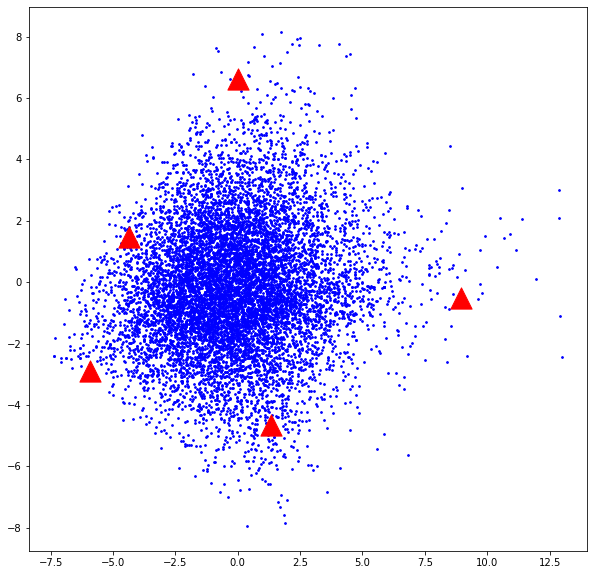

In [28]:
_2dplot(Z,X)

In [32]:
def _barplot(Z,columns):
    archetype_num = 1
    for archetype in Z.T:
        fig, ax = plt.subplots()
        ax.set_ylabel('Value')
        ax.set_title('Archeype {0}'.format(archetype_num))
        ax.bar(np.arange(len(archetype)),archetype)
        ax.set_xticks(np.arange(len(archetype)))
        ax.set_xticklabels(labels=columns)
        plt.ylim(np.min(Z-1), np.max(Z+1))
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
            
        fig.set_size_inches(8, 8)
            
        plt.show()
            
        archetype_num += 1

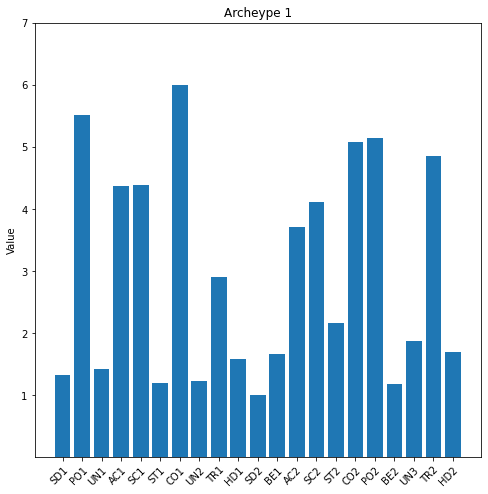

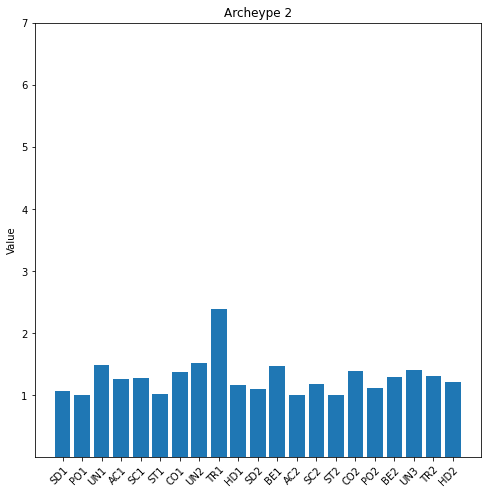

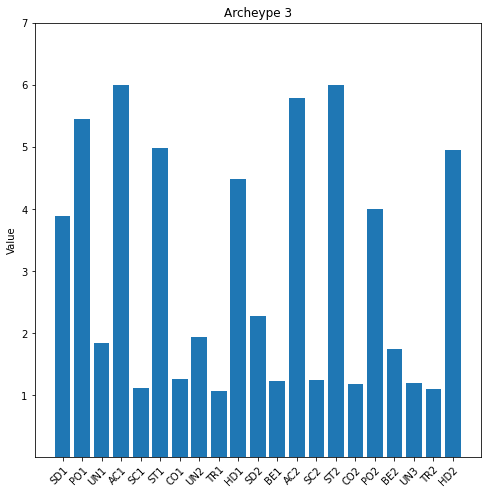

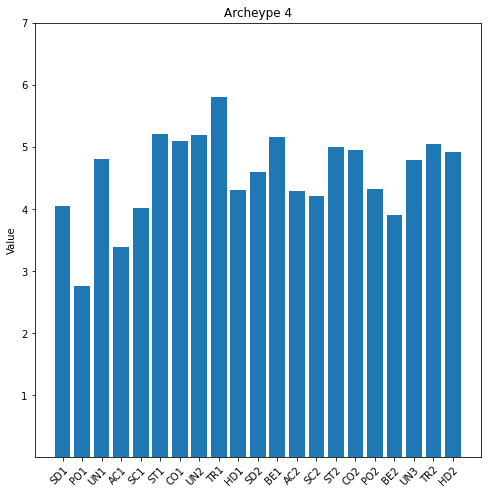

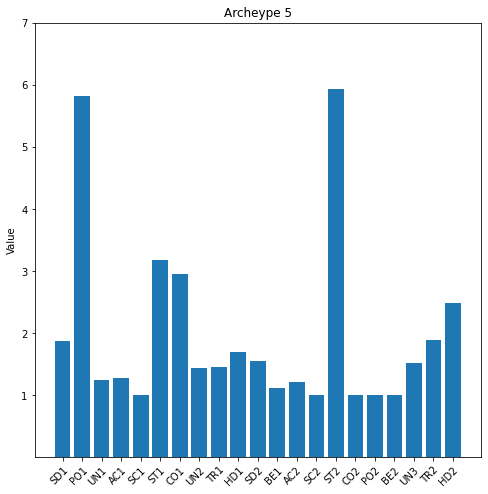

In [33]:
columns = ['SD1', 'PO1', 'UN1', 'AC1', 'SC1',
       'ST1', 'CO1', 'UN2', 'TR1', 'HD1', 'SD2','BE1','AC2', 'SC2', 'ST2',
       'CO2', 'PO2', 'BE2', 'UN3', 'TR2','HD2']

_barplot(Z,columns)